# AIQDSC27 - Machine Learning Algorithms Project

**Student**: Quentin Le Roux

## Instructions

With the available part of the MIMICS dataset, propose the best model (among Linear Regression, KNN, Naive Bayes, RandomForest, SVM) to predict:

> re-hospitalization (evaluation metrics, accuracy)

To build the features (X), all or part of the following columns can be used (all types of pre-processing is allowed):

- DOB: Date of Birth
- GENDER
- MARITAL_STATUS
- ETHNICITY
- INSURANCE
- DEATHTIME: Date of Death (if the patient has died)
- ADMITTIME: Date of the admission
- ADMISSION_TYPE
    - blood, circulatory, congenital, digestive, endocrine, genitourinary, infectious, injury, mental, misc, muscular, neoplasms, nervous, pregnancy, prenatal, respiratory, skin
    - Bag of Words representation of diagnosis
- DISCHTIME: date of the discharge
- DISCHARGE_LOCATION: patient's destination after discharge from hospital
- TEXT: discharge medical report

To build Y, you can use all or part of the following columns (and there too, do the preprocessing you want):

- DAYS_NEXT_ADMIT: number of days between discharge and readmission
- NXT_ADMITTIME: date of readmission
- OUTPUT_LABEL
- DEATHTIME: Date of Death (if the patient has died)

Data leakage (i.e. https://www.kaggle.com/alexisbcook/data-leakage) has to be accounted for/dealt with.

The rendering will be in the form of a jupyter notebook written like a report: with a clearly announced plan, different sections and a conclusion.

A part of the grade will be given on the quality of the report (8 points), a part on the quality of the work done, and the respect of the methodology (6 points), a part on the quality of the prediction (6 points). 

#### <span style="color:red">Note on Data Leakage</span>

From [Kaggle](https://www.kaggle.com/alexisbcook/data-leakage):

> "Data leakage (or leakage) happens when **your training data contains information about the target**, but similar data will not be available when the model is used for prediction. This leads to high performance on the training set (and possibly even the validation data), but the model will perform poorly in production.
> 
> [...]
> 
> **Target leakage** occurs when your predictors include data that will not be available at the time you make predictions. It is important to think about target leakage in terms of the timing or chronological order that data becomes available, not merely whether a feature helps make good predictions.
> 
> [...] 
> 
> Validation is meant to be a measure of how the model does on data that it hasn't considered before. You can corrupt this process in subtle ways if the validation data affects the preprocessing behavior. This is sometimes called **train-test contamination**."

#### <span style="color:red">Note on the required models</span>

The mentioned models are:

- *Linear Regression*
- KNN
- Naive Bayes
- RandomForest
- SVM

Linear Regression is a **regression** model while the three others are **classification** models. We will replace it by a **logistic regression** as a classification model to perform more classification comparisons.

Our comparison of linear regression model (i.e. Lasso, Ridge, ElasticSearch) is available in our other exercise AIQDSC28.

## 0. Table of Content

1. **Introduction**

    a. Overview of project
    
    b. Library imports 
    
    c. Custom functions


2. **Pre-processing**

    a. Methodology
    
    b. Data pre-processing


3. **Modeling**

    a. Logistic Regression
    
    b. KNN
    
    c. Naive Bayes
    
    d. Random Forest
    
    e. SVM
    
    f. Boosting
    
    g. Summarizing results
 
 
4. **Exploring our best model**

    a. Removing ETHNICITY from the dataset
    
    b. Performing PCA on our Bag of Words representation
    
    b. Binary classification
    
    c. Overall parameter impact overview


5. **Conclusion**

    a. Model Choice

    b. Best Model Parameters
    
    c. Looking for ways to improve the predictions
    
    d. Further explorations?

## 1. Introduction

### 1.1 Overview of project

The following project will be **organized in three parts**: i) pre-processing, ii) training models with and without the provided TEXT variable, iii) concluding and offering other areas of explorations.

<u>1 - **Data pre-processing**:</u>

The goal is to build a training and testing set of features based on the content of the MIMIC dataset subset we have been provided. Our preprocessing will follow the following steps:

    1. Loading the training and test sets

    2. Identifying the features at risk of data leakage

    3. Selecting our feature variables (X) and target variable (Y)

    4. Performing pre-processing on our target variable (Y)
        
    5. Performing pre-processing on our feature variables (X)


<u>2 - **Training our models models**:</u>

We will proceed with the main section of the exercise: performing classification. 

**We will split our neural network training process between models**:

- Logistic Regression

- KNN

- Naive Bayes

- RandomForest

- SVM

- Boosting
    
<u>3 - **Results Comparison**:</u>

We will then **select the most promising of the four six models** and perform further hyperparameter tuning, dataset refining, etc. to increase the model's performance

Finally, we will conclude and propose further areas of exploration.

<hr>

<span style="color:red">At each step, we will be careful to highlight our comments and notes</span>.

### 1.2 Library imports and built functions

In [1]:
import datetime as dt
import math
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd

import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)
import warnings
warnings.filterwarnings('ignore')

from itertools import cycle

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, r2_score, accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

### 1.3 Custom functions

In [2]:
def remove_stop_words(tokenized_sentence):
    """
    Removes stop words from a nltk-tokenized sentence
    """
    punctuation = [".", ",", "[", "]", "`", "(", ")", 
                   "?", "'", "'s", ":", "!"]
    stop_words = stopwords.words('english')
    stop_words += punctuation
    return [w for w in tokenized_sentence if w not in stop_words]

In [3]:
def lemmatize(tokenized_sentence):
    """
    Creates a lemmatizer object and lematized a nltk-tokenized 
    sentences. Might require running nltk.download('wordnet') 
    beforehand.
    """
    lemmatizer = nltk.WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in tokenized_sentence]

In [4]:
# Lambda function chaining tokenize, remove_stop_words, and lemmatize

sentence_processing = lambda sentence: " ".join(
    lemmatize(
        remove_stop_words(
            word_tokenize(str.lower(str(sentence)))
        )
    )
)

In [5]:
def confusion(model, X, y, title):
    """
    Prints a confusion matrix of a classification model
    """
    disp = plot_confusion_matrix(model, 
                                 X, 
                                 y,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    disp.ax_.set_title(title)

In [6]:
def classification_score(pred_train, pred_test, y_train, y_test):
    """
    Prints the accuracy and F1 scores for train and test sets of a 
    classification model
    """
    f1_score_train = f1_score(pred_train, y_train, average='weighted')
    acc_score_train = accuracy_score(pred_train, y_train)
    f1_score_test = f1_score(pred_test, y_test, average='weighted')
    acc_score_test = accuracy_score(pred_test, y_test)
    print("--- Train Set Scores ---")
    print("Accuracy: %.2f" % acc_score_train)
    print("F1 score: %.2f" % f1_score_train)
    print("\n--- Test Set Scores ---")
    print("Accuracy: %.2f" % acc_score_test)
    print("F1 score: %.2f" % f1_score_test)
    return acc_score_train, acc_score_test, f1_score_train, f1_score_test

## 2. Pre-processing

### 2.1 Methodology
    
Our data pre-processing will be performed through the following steps:
 
<u>1 - **Loading the training and testing sets**:</u>

Our dataset loading will rely on a local copy of the dataset, however the code to retrieve the dataset online is also included, albeit commented out.

We will also provide preliminary notes on the training and testing sets' content (e.g. number of elements, etc.).

<u>2 - **Identifying the features at risk of data leakage**:</u>

Based on those preliminary notes, we will look into identifying the available features (in our case columns in a DataFrame) which are at most risk of data leakage. 

<u>3 - **Selecting our feature variables (X) and target variable (Y)**:</u>

Based on our observations, we will be performing a variable selection, identifying which columns of the imported dataset will be used for building our features (i.e. the X of the model), and which will be used to build our target variable (i.e. the Y of the model).

<u>4 - **Performing pre-processing on our target variable (Y)**:</u>

We will start with pre-processing our target variable by:

    1. Removing NaN values (from our Y and X DataFrames)
    
    2. Potentially rescaling our target variable

<u>5 - **Performing pre-processing on our feature variables (X)**:</u>

Based on our assumption above, we will be performing the following steps as part of our feature pre-processing:

    1. Highlighting remaining NaN values and deciding how to pre-process them

    2. Building a LENGTH_OF_STAY and AGE features from our pre-existing data
    
    3. One-hot encoding the discrete features we ended up selecting
    
    4. Building an embedding representation of the DIAGNOSIS feature
    
To build our embedding for DIAGNOSIS, we will use the CountVectorizer method.

### 2.2 Data Pre-processing

#### 2.2.1 - <u>Loading the training and test sets:</u>

As seen below, we load the provided datasets and also create placeholder variables. These will hold the processed training and testing data so that we do not erase the original data.

Given those loaded sets, our preliminary observations are the following:

1. We find that the training dataset holds **2000 entries**, while the testing dataset holds **901 entries**, i.e.: 

    - A 69 to 31 train-test ratio
    
    - <u>Note:</u> A usual rule of thumb for a small dataset is to usually perform a 80 to 20 train-test split, which the current split satisfies. As such, we keep the split as-is.


2. Several features present **NaN values**, i.e.:

    - we will need to decide what to do with them after variable selection.


3. The available features are of types **int64** or **Object**, i.e.:

    - We might have to perform data-wrangling to transform the data into types usable by a machine learning model.


4. A Bag of Word embedding for the DIAGNOSIS column has been provided:

    - As seen in the [MIMIC-III Clinical Database Demo 1.4](https://physionet.org/content/mimiciii-demo/1.4/ADMISSIONS.csv), the DIAGNOSIS column corresponds to a string value that includes a list of diagnoses separated by multiple kinds of characters (e.g. ' **/** ', ' **;** ', ' **,** ', ' **-** ', etc.). 
    - The bag of words representation displays non-binary numeric (integer) values, for which we do not have much information. We could infer that it may represent some kind of importance associated with each word.
    - Nevertheless, given the lack of information on the way the bag of words was created, **we might want to create our own word embedding representation for DIAGNOSIS, discarding the existing one**.

<hr>

In [7]:
local_train_set_path = "./datasets/train.csv.zip"
local_test_set_path = "./datasets/test.csv.zip"

df_train = pd.read_csv(local_train_set_path)
df_test = pd.read_csv(local_test_set_path)

In [8]:
# comment the lines above and uncomment the lines below for retrieving the 
# dataset from the online unice repository

# df_train = pd.read_csv(train_set_path)
# df_train = pd.read_csv(test_set_path)

# online_path = 
# "http://www.i3s.unice.fr/~riveill/dataset/MIMIC-III-readmission/"
# train_set_path = online_path + "train.csv.zip"
# test_set_path = online_path + "test.csv.zip"

In [9]:
X_train_without_TEXT = None
X_test_without_TEXT = None

In [10]:
y_train = None
y_test = None

<u>Preliminary information on the sets:</u>

In [11]:
df_train.describe()

,SUBJECT_ID,HADM_ID,DAYS_NEXT_ADMIT,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,...,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,OUTPUT_LABEL
count,2000.000000,2000.000000,1210.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0000
mean,18155.690500,150103.483000,119.883433,0.482500,2.858000,0.036000,0.747500,1.389000,0.660500,0.438500,...,0.447500,0.430500,0.216000,0.255500,0.421000,0.008000,0.119000,0.972500,0.189000,0.5050
std,26240.378348,29205.036893,404.753993,0.735503,2.253969,0.196783,1.179593,1.329121,0.895902,0.809658,...,0.847114,0.739894,0.544511,0.704605,0.801299,0.151484,0.376709,1.199359,0.551753,0.5001
min,11.000000,100095.000000,-0.602083,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
25%,1490.500000,124979.500000,5.383333,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
50%,3103.500000,150743.500000,13.219792,0.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0000
75%,25072.750000,174570.750000,25.327951,1.000000,4.000000,0.000000,1.000000,2.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,1.0000
max,99562.000000,199955.000000,3867.977778,5.000000,13.000000,2.000000,9.000000,10.000000,4.000000,7.000000,...,9.000000,5.000000,5.000000,8.000000,7.000000,4.000000,5.000000,6.000000,6.000000,1.0000


In [12]:
df_test.describe()

,SUBJECT_ID,HADM_ID,DAYS_NEXT_ADMIT,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,...,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,OUTPUT_LABEL
count,901.000000,901.000000,526.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,...,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000
mean,18306.197558,149172.830189,84.578517,0.466149,2.817980,0.044395,0.728080,1.372919,0.700333,0.468368,...,0.468368,0.436182,0.201998,0.243063,0.440622,0.015538,0.119867,0.931188,0.241953,0.503885
std,26349.689656,29115.501914,304.437951,0.691390,2.256878,0.231479,1.165418,1.406611,0.944628,0.804397,...,0.919147,0.752463,0.538760,0.682942,0.784625,0.253383,0.354423,1.184030,0.624726,0.500263
min,6.000000,100039.000000,-0.454167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1521.000000,123423.000000,5.100868,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3176.000000,147718.000000,11.302431,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,25256.000000,174749.000000,22.211632,1.000000,4.000000,0.000000,1.000000,2.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,1.000000
max,99982.000000,199807.000000,3543.101389,4.000000,12.000000,2.000000,7.000000,7.000000,5.000000,7.000000,...,6.000000,5.000000,5.000000,5.000000,4.000000,5.000000,3.000000,7.000000,6.000000,1.000000


In [13]:
# We find that only the columns MARITAL_STATUS and DIAGNOSIS have NaN values 
# in both the training and testing dataset.

print(df_train.isnull().sum(),
      df_test.isnull().sum(),
      sep="\n\n")

SUBJECT_ID               0
HADM_ID                  0
ADMITTIME                0
DISCHTIME                0
DAYS_NEXT_ADMIT        790
NEXT_ADMITTIME         790
ADMISSION_TYPE           0
DEATHTIME             1842
DISCHARGE_LOCATION       0
INSURANCE                0
MARITAL_STATUS          76
ETHNICITY                0
DIAGNOSIS                2
TEXT                    75
GENDER                   0
DOB                      0
blood                    0
circulatory              0
congenital               0
digestive                0
endocrine                0
genitourinary            0
infectious               0
injury                   0
mental                   0
misc                     0
muscular                 0
neoplasms                0
nervous                  0
pregnancy                0
prenatal                 0
respiratory              0
skin                     0
OUTPUT_LABEL             0
dtype: int64

SUBJECT_ID              0
HADM_ID                 0
ADMITTIME       

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SUBJECT_ID          2000 non-null   int64  
 1   HADM_ID             2000 non-null   int64  
 2   ADMITTIME           2000 non-null   object 
 3   DISCHTIME           2000 non-null   object 
 4   DAYS_NEXT_ADMIT     1210 non-null   float64
 5   NEXT_ADMITTIME      1210 non-null   object 
 6   ADMISSION_TYPE      2000 non-null   object 
 7   DEATHTIME           158 non-null    object 
 8   DISCHARGE_LOCATION  2000 non-null   object 
 9   INSURANCE           2000 non-null   object 
 10  MARITAL_STATUS      1924 non-null   object 
 11  ETHNICITY           2000 non-null   object 
 12  DIAGNOSIS           1998 non-null   object 
 13  TEXT                1925 non-null   object 
 14  GENDER              2000 non-null   object 
 15  DOB                 2000 non-null   object 
 16  blood 

In [15]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901 entries, 0 to 900
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SUBJECT_ID          901 non-null    int64  
 1   HADM_ID             901 non-null    int64  
 2   ADMITTIME           901 non-null    object 
 3   DISCHTIME           901 non-null    object 
 4   DAYS_NEXT_ADMIT     526 non-null    float64
 5   NEXT_ADMITTIME      526 non-null    object 
 6   ADMISSION_TYPE      901 non-null    object 
 7   DEATHTIME           58 non-null     object 
 8   DISCHARGE_LOCATION  901 non-null    object 
 9   INSURANCE           901 non-null    object 
 10  MARITAL_STATUS      861 non-null    object 
 11  ETHNICITY           901 non-null    object 
 12  DIAGNOSIS           901 non-null    object 
 13  TEXT                871 non-null    object 
 14  GENDER              901 non-null    object 
 15  DOB                 901 non-null    object 
 16  blood   

<hr>

#### 2.2.2 - <u>Identifying the features at risk of data leakage:</u>

We need to look into identifying the available features (in our case columns in a DataFrame) which are at most risk of data leakage. We focus on two cases:

    1. Mismatched entries related to a single patient
    
Indeed, it is possible that a single patient (i.e. a single SUBJECT_ID) has multiple entries in the dataset. Based on the [information provided by the repository for the MIMIC dataset](https://mimic.physionet.org/mimictables/admissions/), HADM_ID represents a single patient’s admission(s) to the hospital and SUBJECT_ID represents a single patient.
    
    2. Data leakage between a potential target variable and potential feature variables

Indeed, some features leak information about a potential target variable. For instance, we see that DISCHARGE_LOCATION and TEXT hold important data with regards to the outcome of the patient's stay.

To highlight those risks, we provide the three following examples (including code in the cells below):

**Patient (SUBJECT_ID) 17 (see code below)**:

By looking at the number of times a single patient has been admitted to the hospital, we want to find whether a single patient may have been admitted more than once and whether it is reflected in the dataset. 

    - We find that patients have been admitted up to 15 times in the training set.
    
As an example, the patient 17 has been admitted twice.

**Patient (SUBJECT_ID) 808 (see code below)**:

We see that patient 808 has three referenced admissions but the last record mentions a readmission date that is not referenced in the dataset. The admit times are also mismatched. 

    - There are 3 admissions with each showing a next admission time, implying at least 
    one admission is missing from the dataset.

**Patient (SUBJECT_ID) 937 (see code below)**:

As part of our data leakage check, we want to check whether patients have a number of rows equal to the number of admissions mentioned in the related data (i.e. we would expect a patient with 1 readmission to have two lines in the dataset). Furthermore, we want to see if potential feature columns reference potential target data. We find that:

    - Some patients have a mismatch between the number of mentioned readmission dates and 
    the number of lines associated to their ID.
    
We can interpret this fact as such: The dataset cannot be understood as a time series. As such, each row (and their potential readmission) should be construed as independent from other rows. This implies that, in terms of data leakage, we should individualize each row in a way that no two rows can be linked to each other (independence).

We find that patient 937 has been admitted twice but has only one single record in the training dataset. 
    
    - Some columns, such as DISCHARGE_LOCATION and TEXT, hold important data with regards 
    to the outcome of the patient's stay

Furthermore, some features leak information about a potential target variable. 

Indeed, we see, for patient 937, that DISCHARGE_LOCATION and TEXT hold important data with regards to the outcome of the patient's stay. However, since this data seems mostly related to the death of the patient, and that results in a NaN value for the number of days to the next re-hospitalization, we know that this row will not be included in our dataset (as per the assumption on the target variable made in the previous part of this report).

<hr>

<u>Patient 17:</u>

In [16]:
df_train.pivot_table(index = ['SUBJECT_ID'], aggfunc ='size').unique()

array([ 1,  2, 15,  3,  5,  4,  6,  8])

In [17]:
print(df_train.pivot_table(index = ['SUBJECT_ID'], aggfunc ='size').head(2))
df_train[df_train["SUBJECT_ID"]==17]

SUBJECT_ID
11    1
17    2
dtype: int64


,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DAYS_NEXT_ADMIT,NEXT_ADMITTIME,ADMISSION_TYPE,DEATHTIME,DISCHARGE_LOCATION,INSURANCE,...,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,OUTPUT_LABEL
1182,17,161087,2135-05-09 14:11:00,2135-05-13 14:40:00,NaN,NaN,EMERGENCY,NaN,HOME HEALTH CARE,Private,...,1,1,2,0,0,0,0,1,0,0
1710,17,194023,2134-12-27 07:15:00,2134-12-31 16:05:00,128.920833,2135-05-09 14:11:00,ELECTIVE,NaN,HOME HEALTH CARE,Private,...,0,0,0,0,0,0,0,0,0,0


<u>Patient 808:</u>

In [18]:
df_train[df_train["SUBJECT_ID"]==808]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DAYS_NEXT_ADMIT,NEXT_ADMITTIME,ADMISSION_TYPE,DEATHTIME,DISCHARGE_LOCATION,INSURANCE,...,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,OUTPUT_LABEL
553,808,197130,2181-11-16 08:18:00,2181-11-23 09:04:00,8.701389,2181-12-02 01:54:00,EMERGENCY,NaN,HOME HEALTH CARE,Private,...,0,0,0,2,0,0,0,3,0,1
1189,808,100677,2181-07-12 20:11:00,2181-07-17 13:14:00,13.395833,2181-07-30 22:44:00,EMERGENCY,NaN,HOME HEALTH CARE,Private,...,0,1,0,3,0,0,0,0,0,1
1995,808,139077,2181-05-11 16:57:00,2181-05-16 11:58:00,13.701389,2181-05-30 04:48:00,EMERGENCY,NaN,HOME,Private,...,0,0,0,0,0,0,0,2,0,1


<u>Patient 937:</u>

In [19]:
df_train[df_train["SUBJECT_ID"]==937]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DAYS_NEXT_ADMIT,NEXT_ADMITTIME,ADMISSION_TYPE,DEATHTIME,DISCHARGE_LOCATION,INSURANCE,...,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,OUTPUT_LABEL
0,937,148592,2163-01-20 18:39:00,2163-01-24 08:00:00,0.061806,2163-01-24 09:29:00,EMERGENCY,2163-01-26 08:00:00,DEAD/EXPIRED,Medicare,...,0,0,0,0,1,0,0,0,0,1


In [20]:
# DISCHARGE_LOCATION holds important data on the fate of patient 937.

df_train[df_train["SUBJECT_ID"]==937]["DISCHARGE_LOCATION"]

0    DEAD/EXPIRED
Name: DISCHARGE_LOCATION, dtype: object

In [21]:
# TEXT holds important data on the fate of patient 937:
#     Discharge Disposition:\nExpired\n\nDischarge Diagnosis:\n1.  
#     intraparenchymal hemmorrhage\n\nDischarge Condition:\nexpired

print(df_train[df_train["SUBJECT_ID"]==937]["TEXT"].values)

['Admission Date:  [**2163-1-20**]              Discharge Date:   [**2163-1-24**]\n\nDate of Birth:  [**2087-9-24**]             Sex:   M\n\nService: NEUROLOGY\n\nAllergies:\nPatient recorded as having No Known Allergies to Drugs\n\nAttending:[**First Name3 (LF) 5868**]\nChief Complaint:\ntransfer from ICH with intra-parenchymal bleed\n\nMajor Surgical or Invasive Procedure:\nnone\n\nHistory of Present Illness:\nThe patient is a 75 year old man with a history of hypertension\nand high cholesterol, now presenting on transfer from an OSH\nwith\na large right intraparenchymal cerebral bleed.  As per his\nchart, he originally presented to the OSH with the complaint of\ninability to feel his right leg.  An angiogram of the leg\nuncovered a right femoral artery occlusion and he was given t-\nPA (iv).  The next morning, the patient developed a left\nhemiparesis with left facial droop and a right gaze preference.\nAn emergent CT scan of his brain showed multiple hemorrhages\nprimarily in the r

<hr>

#### 2.2.3 - <u>Selecting our feature variables (X) and target variable (Y):</u>

<u>1 - Selecting our target variable (Y):</u>

We can predict if a patient will **i)** be readmitted at some point, **ii)** die, **iii)** be discharged without readmission

We can assign a tag to each of the scenarios above which will be used to perform classification

<u>2 - Selecting our feature variables (X)</u>

We decide that, due to data leakage concerns, to not focus on the following variables:  ADMITTIME, DISCHTIME (those are obvious data leakage risk as they give information on actual readmission rates), DEATHTIME, DISCHARGE_LOCATION and TEXT (those may in theory hold important information on the end fate of the patient, meaning we cannot include those features as it would leak information with regards to the outcome we want to predict), and finally the provided bag of words (of the DIAGNOSIS column, which we discard as we will be building our own embedding).

As such, we focus on the following features:

    - Age (which we will have to construct out of DOB and ADMITTIME)
    - GENDER
    - MARITAL_STATUS
    - ETHNICITY (see note)
    - INSURANCE
    - ADMISSION_TYPE
    - Length of stay (which we will have to construct out of DISCTIME and ADMITTIME)
    - DIAGNOSIS (from which we will build our own bag of words representation)

<u>3 - Note on ETHNICITY:</u>

It is important to note that ethnic/racial data is a controversial topic in AI. The goal is to avoid racial profiling as well as racial discrimination. Especially in health. 

It happens that systemic racism and poverty greatly affect minorities in the United States. We recall that the [MIMIC dataset is a relational database containing tables of data relating to patients who stayed within the intensive care units](https://mimic.physionet.org/gettingstarted/overview/) at [Beth Israel Deaconess Medical Center in Boston, MA, USA](https://en.wikipedia.org/wiki/Beth_Israel_Deaconess_Medical_Center). The hospital is a *private* teaching center attached to the Harvard Medical School. In Massachusetts, [poverty afflicts minorities about twice as much as white people](https://www.welfareinfo.org/poverty-rate/massachusetts/).

As such, ethnicity may have a strong impact on both the quality of their care, their access to insurance, and in the end their potential rate of readmission, etc.

Nevertheless, for the purpose of the exercise (given that trying models with and without the variable is computationally expensive), we will keep the variable for now.

<u>4 - Note on TEXT and DISCHARGE_LOCATION:</u>

As we saw in the cell above, TEXT and DISCHARGE_LOCATION may hold important information on the end fate of the patient, meaning we cannot include those features as **it would leak information with regards to the outcome we want to predict**.

<hr>

In [22]:
feature_columns = ["DOB", "GENDER", "MARITAL_STATUS", "ETHNICITY", "INSURANCE", 
                   "ADMISSION_TYPE", "DIAGNOSIS", "ADMITTIME", "DISCHTIME"]
target_column = "DAYS_NEXT_ADMIT"

# We copy the selected variables from the imported datasets

X_train = df_train[feature_columns].copy()
X_test = df_test[feature_columns].copy()

y_train = df_train[target_column].copy()
y_test = df_test[target_column].copy()

<hr>

#### 2.2.4 - <u>Performing pre-processing on our target variable (Y):</u>

    1. Removing NaN values (from our Y and X DataFrames)

Given the assumption cited above (i.e., *Since our goal is to predict (via regression) the number of days to next re-hospitalization, we will be removing from the dataset individuals which do not have a readmission date (represented as NaN values*), we record the indexes where our target variable Y contains NaN values and remove the corresponding rows from both our target and feature DataFrames.

    2. Pre-processing our target variable

We proceed with the following assumptions:

1. if DEATHTIME is not NaN, the patient is classified as "dead"
2. if DAYS_NEXT_ADMIT are not NaN, the patient is classified as "will be readmitted"
3. if neither DEATTIME or DAYS_NEXT_ADMIT are NaN, the patient is classified as "will not be readmitted" (i.e. remission)

<hr>

In [23]:
# We record the DAYS_NEXT_ADMIT, NEXT_ADMITTIME, DEATHTIME columns

y_train = df_train[["DAYS_NEXT_ADMIT", "DEATHTIME"]].copy()
y_test = df_test[["DAYS_NEXT_ADMIT", "DEATHTIME"]].copy()

print(y_train.isnull().sum(),
      y_test.isnull().sum(),
      sep="\n")

DAYS_NEXT_ADMIT     790
DEATHTIME          1842
dtype: int64
DAYS_NEXT_ADMIT    375
DEATHTIME          843
dtype: int64


In [24]:
# Based on our classification assumptions we construct a target 
# variable with the following values:

for table in [y_train, y_test]:
    # "DEAD" if DEATHTIME is not NaN
    # "READMISSION" if DAYS_NEXT_ADMIT are not NaN
    # "REMISSION" if neither DEATTIME or DAYS_NEXT_ADMIT are NaN
    table["OUTCOME"] = "READMISSION"
    table["OUTCOME"][table["DEATHTIME"].isnull()==False] = "DEAD"
    table["OUTCOME"][table["DAYS_NEXT_ADMIT"].isnull() &
                     table["DEATHTIME"].isnull()] = "REMISSION"
    # we drop columns as they are not useful anymore
    table.drop(["DAYS_NEXT_ADMIT"], axis = 1, inplace = True)
    table.drop(["DEATHTIME"], axis = 1, inplace = True)

In [25]:
# We check our target variables (with the example of the train target
# variables)

y_train.value_counts()

OUTCOME    
READMISSION    1194
REMISSION       648
DEAD            158
dtype: int64

<hr>

#### 2.2.5 - <u>Performing pre-processing on our feature variables (X):</u>

    1. Removing the feature rows (i.e. data points) which correspond to NaN values in the target 
    variable Y
    
Done in 2.2.4.
    
    2. Highlighting remaining NaN values and deciding how to pre-process them

As we see in the first code cell below, NaN values are found only in the MARITAL_STATUS, DIAGNOSIS and TEXT columns only after the previous cleaning. As we plan on performing a One-Hot Encoding for the former and a Bag of Words embedding for the latter, we will not remove those rows as they will be transformed into features.

    3. Building a LENGTH_OF_STAY and AGE features from our pre-existing data
    
We build a length of stay variable by taking the difference between ADMITTIME and DISCTIME (in days). We proceed as such:

- convert ADMITTIME and DISCTIME dates to datetime
- calculate the float value timedelta (in days)
- drop DISCHTIME as it is not useful anymore
- rescale the variable using a MinMaxScaler

We build an age variable by taking the difference between ADMITTIME and DOB (in year). We proceed as such:

- convert dates to year
- calculate the float value timedelta (in year)
- drop ADMITTIME and DOB as they are not useful anymore
- rescale the variable using a MinMaxScaler

Before applying the MinMaxScaler, we find that some ages are impossible (being well above the oldest recorded age for a human being), leading to think that the dataset has misrecorded values. To deal with those, we decide to replace these erroneous values with the average age of the rest of the dataset (i.e. the mean of all ages that are not impossible). We proceed as such:

- calculate the average age in the rest of the train dataset
- replace the wrong age values with the calculated average in both the train and test dataset

119 rows are impacted. 


    4. One-hot encoding the discrete features we ended up selecting
 
We build one-hot encoding for each discrete/categorical variables we decided to keep: GENDER, MARITAL_STATUS, ETHNICITY, INSURANCE, ADMISSION_TYPE
    
    5. Building an embedding representation of the DIAGNOSIS column

We want to build our own Bag of Words representation of the DIAGNOSIS column, using the sklearn CountVectorizer object. We proceed as such:

- pre-process the content of the DIAGNOSIS column
- declare and fit the CountVectorizer object
- transform the diagnosis column using the count vectorizer
- expand the resulting feature matrix into individual columns
- drop the DIAGNOSIS columns to clean up the dataset

<hr>

<u>Highlighting remaining NaN values and deciding how to pre-process them:</u>

In [26]:
print(X_train.isnull().sum(),
      X_test.isnull().sum(),
      sep="\n\n")

DOB                0
GENDER             0
MARITAL_STATUS    76
ETHNICITY          0
INSURANCE          0
ADMISSION_TYPE     0
DIAGNOSIS          2
ADMITTIME          0
DISCHTIME          0
dtype: int64

DOB                0
GENDER             0
MARITAL_STATUS    40
ETHNICITY          0
INSURANCE          0
ADMISSION_TYPE     0
DIAGNOSIS          0
ADMITTIME          0
DISCHTIME          0
dtype: int64


<u>Building LENGTH_OF_STAY (in days):</u>

In [27]:
#Building the variable
X_train["ADMITTIME"] = pd.to_datetime(X_train["ADMITTIME"])
X_train["DISCHTIME"] = pd.to_datetime(X_train["DISCHTIME"])
X_train["LENGTH_OF_STAY"] = X_train["DISCHTIME"] - X_train["ADMITTIME"]
X_train["LENGTH_OF_STAY"] = X_train["LENGTH_OF_STAY"].dt.total_seconds() / (24 * 60 * 60)

X_test["ADMITTIME"] = pd.to_datetime(X_test["ADMITTIME"])
X_test["DISCHTIME"] = pd.to_datetime(X_test["DISCHTIME"])
X_test["LENGTH_OF_STAY"] = X_test["DISCHTIME"] - X_test["ADMITTIME"]
X_test["LENGTH_OF_STAY"] = X_test["LENGTH_OF_STAY"].dt.total_seconds() / (24 * 60 * 60)

X_train.drop(["DISCHTIME"], axis = 1, inplace = True)
X_test.drop(["DISCHTIME"], axis = 1, inplace = True)

In [28]:
# Rescaling
min_max = MinMaxScaler()

var_train = pd.DataFrame(X_train["LENGTH_OF_STAY"])
var_test = pd.DataFrame(X_test["LENGTH_OF_STAY"])

min_max.fit(var_train)
X_train["LENGTH_OF_STAY"] = min_max.transform(var_train)
X_test["LENGTH_OF_STAY"] = min_max.transform(var_test)

<u>Building AGE (in year):</u>

In [29]:
X_train["DOB"] = pd.to_datetime(X_train["DOB"]).dt.year
X_train["ADMITTIME"] = X_train["ADMITTIME"].dt.year
X_train["AGE"] = X_train["ADMITTIME"] - X_train["DOB"]

X_test["DOB"] = pd.to_datetime(X_test["DOB"]).dt.year
X_test["ADMITTIME"] = X_test["ADMITTIME"].dt.year
X_test["AGE"] = X_test["ADMITTIME"] - X_test["DOB"]

X_train.drop(["ADMITTIME", "DOB"], axis = 1, inplace = True)
X_test.drop(["ADMITTIME", "DOB"], axis = 1, inplace = True)

In [30]:
# Some calculated ages are well above possible values.
print(sorted(X_train["AGE"].unique()),
      sorted(X_test["AGE"].unique()),
      sep="\n\n")
# There are 119 age value above 122 (the oldest recorded age in a human)
print(len(X_train[X_train["AGE"]>122]))

[0, 1, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 300, 301, 302, 303, 305, 306, 307, 308, 310]

[0, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 300, 301, 302, 303, 305, 308]
119


In [31]:
# Replacing the impossible ages with the average age in the dataset
average_age = X_train[X_train["AGE"]<=89]["AGE"].mean()
X_train.loc[(X_train.AGE > 89), 'AGE'] = average_age
X_test.loc[(X_test.AGE > 89), 'AGE'] = average_age

In [32]:
# Rescaling
min_max = MinMaxScaler()

var_train = pd.DataFrame(X_train["AGE"])
var_test = pd.DataFrame(X_test["AGE"])

min_max.fit(var_train)
X_train["AGE"] = min_max.transform(var_train)
X_test["AGE"] = min_max.transform(var_test)

<u>One-hot encoding the discrete features we ended up selecting:</u>

In [33]:
dummy_list = ["GENDER", "MARITAL_STATUS", "ETHNICITY", "INSURANCE", "ADMISSION_TYPE"]

X_train = pd.get_dummies(X_train, columns = dummy_list)
X_test = pd.get_dummies(X_test, columns = dummy_list)

<u>Building an embedding representation of the text features we ended up selecting:</u>

**DIAGNOSIS**:

In [34]:
X_train["DIAGNOSIS"] = X_train["DIAGNOSIS"].apply(sentence_processing)
X_test["DIAGNOSIS"] = X_test["DIAGNOSIS"].apply(sentence_processing)

In [35]:
cv = CountVectorizer(analyzer="word", ngram_range=(1,1), stop_words="english")
cv.fit(X_train["DIAGNOSIS"].tolist())

tf = lambda s: cv.transform([s]).todense().tolist()[0]
X_train["DIAGNOSIS"] = X_train["DIAGNOSIS"].apply(tf)
X_test["DIAGNOSIS"] = X_test["DIAGNOSIS"].apply(tf)

X_train[cv.get_feature_names()] = pd.DataFrame(X_train["DIAGNOSIS"].tolist(), 
                                               index= X_train.index)
X_test[cv.get_feature_names()] = pd.DataFrame(X_test["DIAGNOSIS"].tolist(), 
                                               index= X_test.index)

In [36]:
X_train.drop(["DIAGNOSIS"], axis=1, inplace=True)
X_test.drop(["DIAGNOSIS"], axis=1, inplace=True)

In [37]:
print(f"Number of created embeddings: {len(cv.get_feature_names())}.",
      cv.get_feature_names()[:100],
      sep="\n\n")

Number of created embeddings: 819.

['1st', '21', '22', 'abcess', 'abd', 'abdcess', 'abdomal', 'abdomen', 'abdominal', 'ablation', 'abscess', 'abuse', 'accending', 'access', 'accident', 'account', 'achalasia', 'acidosis', 'acitic', 'acsites', 'acute', 'advancement', 'afib', 'aicd', 'air', 'airway', 'alcohol', 'als', 'altered', 'aml', 'anasarca', 'anemia', 'aneursym', 'aneurysm', 'angina', 'angio', 'angiogram', 'angioplasty', 'ankle', 'anomaly', 'anterior', 'antibiotic', 'anticholinergic', 'aorta', 'aortic', 'appendicitis', 'approach', 'ar', 'arachnoid', 'arch', 'arf', 'arrest', 'arterial', 'artery', 'ascending', 'ascites', 'aspiration', 'assault', 'asthma', 'asthmaticus', 'ataxia', 'atriacure', 'atrial', 'atrioventricular', 'attach', 'attack', 'aureus', 'av', 'avascular', 'avr', 'axillo', 'bacteremia', 'bacterial', 'benign', 'bental', 'bentall', 'benzodiazepine', 'bi', 'bifemoral', 'bilateral', 'bile', 'bili', 'biliary', 'biventricular', 'bladder', 'bled', 'bleed', 'bleeding', 'block',

<hr>

## 3. Providing a baseline with non-deep learning models

Our Classification modeling comparison will focus on two score metrics:

- **Accuracy score**

> The accuracy score represents the ability of a model to correctly predict the label of each data point in a set. Mathematically, it represents the ratio of sum of true positive and true negatives out of all the predictions

$$ {ACC} = \frac{TP + TN}{TP+FN+TN+FP} $$

With $ TP $ the true positives, $ FN $ the false negatives, $ TN $ the true negatives, and $ FP $ the false positives.

- **F1 score**

> The F1 score represents a function of the model's precision (proportion of positive identifications that are actually correct) and recall (proportion of actual positive identifications that were identified correctly) scores. 
>
> This is a useful measure of the model while trying to optimize either or both of precision or recall score of the model.

$$ {Precision} = \frac{TP}{FP+TP} $$

$$ {Recall} = \frac{TP}{FN + TP} $$

$$ {F1\, score} = 2\times\frac{{Precision}\times{Recall}}{{Precision}+{Recall}} $$

<hr>

## 3. Modeling

We propose six different models:

- Logistic Regression

- KNN

- Naive Bayes

- Random Forest

- SVM

- Boosting

Every time we will proceed in two steps:

1. Training a model with default parameters

2. Performing a gridsearch to find the best mix

<hr>

### 3.1 Logistic Regression

We see below that the Logistic Regression model has a difficulty identifying data points tagged with the target variable "DEATH".

#### 3.1.1 Default Parameters

In [38]:
# Model declaration and training

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression()

In [39]:
# Model prediction

lr_pred_train = lr_model.predict(X_train)
lr_pred_test = lr_model.predict(X_test)

In [40]:
# Scores

lr_score = classification_score(lr_pred_train, lr_pred_test, 
                                y_train, y_test)

--- Train Set Scores ---
Accuracy: 0.76
F1 score: 0.78

--- Test Set Scores ---
Accuracy: 0.65
F1 score: 0.68


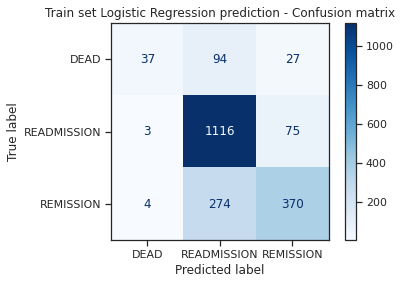

In [41]:
# Confusion Matrices

confusion(lr_model, X_train, y_train, 
          "Train set Logistic Regression prediction - Confusion matrix")

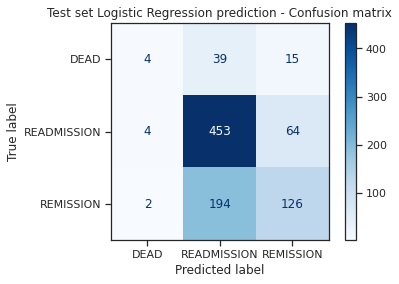

In [42]:
confusion(lr_model, X_test, y_test, 
          "Test set Logistic Regression prediction - Confusion matrix")

#### 3.1.2 GridSearch

In [43]:
# Going further with GridSearch

parameters = {"penalty":("l1", "l2", "elasticnet", "none"),
              "solver":("newton-cg", "lbfgs", "liblinear", "sag", "saga"),
              "max_iter":(100, 300, 500, 1000, 2000)}

# Model declaration and training

lr_model = LogisticRegression()
lr_grid_search = GridSearchCV(lr_model, parameters)
lr_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'max_iter': (100, 300, 500, 1000, 2000),
                         'penalty': ('l1', 'l2', 'elasticnet', 'none'),
                         'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga')})

In [44]:
# Prints the best parameters

lr_grid_search.best_params_

{'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}

In [45]:
# Model prediction

lr_grid_pred_train = lr_grid_search.predict(X_train)
lr_grid_pred_test = lr_grid_search.predict(X_test)

# Scores

lr_grid_score = classification_score(lr_grid_pred_train, lr_grid_pred_test, 
                                     y_train, y_test)

--- Train Set Scores ---
Accuracy: 0.70
F1 score: 0.74

--- Test Set Scores ---
Accuracy: 0.64
F1 score: 0.68


<hr>

### 3.2 KNN

Similar to logistic regression, but at a lesser extent, we see below that the KNN model has a difficulty identifying data points tagged with the target variable "DEATH".

#### 3.2.1 Default Parameters

In [46]:
# Model declaration and training

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [47]:
# Model prediction

knn_pred_train = knn_model.predict(X_train)
knn_pred_test = knn_model.predict(X_test)

In [48]:
# Scores

knn_score = classification_score(knn_pred_train, knn_pred_test, 
                                 y_train, y_test)

--- Train Set Scores ---
Accuracy: 0.72
F1 score: 0.74

--- Test Set Scores ---
Accuracy: 0.57
F1 score: 0.60


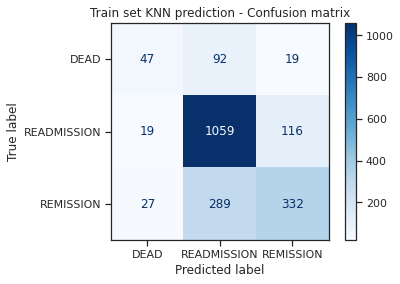

In [49]:
# Confusion Matrices

confusion(knn_model, X_train, y_train, 
          "Train set KNN prediction - Confusion matrix")

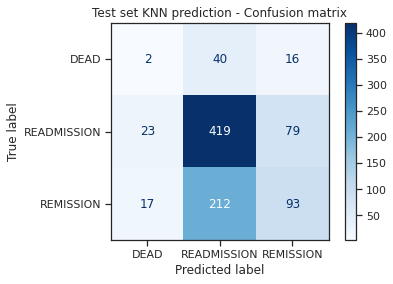

In [50]:
confusion(knn_model, X_test, y_test, 
          "Test set KNN prediction - Confusion matrix")

#### 3.2.2 GridSearch

In [51]:
# Going further with GridSearch

parameters = {"weights":("uniform", "distance"),
              "algorithm":("auto", "ball_tree", "kd_tree", "brute"),
              "n_neighbors": list(range(5, 40))}

# Model declaration and training

knn_model = KNeighborsClassifier()
knn_grid_search = GridSearchCV(knn_model, parameters)
knn_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
                         'n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                         16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                                         26, 27, 28, 29, 30, 31, 32, 33, 34, ...],
                         'weights': ('uniform', 'distance')})

In [52]:
# Prints the best parameters

knn_grid_search.best_params_

{'algorithm': 'auto', 'n_neighbors': 19, 'weights': 'uniform'}

In [53]:
# Model prediction

knn_grid_pred_train = knn_grid_search.predict(X_train)
knn_grid_pred_test = knn_grid_search.predict(X_test)

# Scores

knn_grid_score = classification_score(knn_grid_pred_train, knn_grid_pred_test, 
                                      y_train, y_test)

--- Train Set Scores ---
Accuracy: 0.65
F1 score: 0.71

--- Test Set Scores ---
Accuracy: 0.61
F1 score: 0.68


<hr>

### 3.3 Naive Bayes

Naive Bayes fares much poorer as a model compared to the ones we've seen so far, having a hard time predicting readmissions at all.

#### 3.3.1 Default Parameters

In [54]:
# Model declaration and training

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

GaussianNB()

In [55]:
# Model prediction

nb_pred_train = nb_model.predict(X_train)
nb_pred_test = nb_model.predict(X_test)

In [56]:
# Scores

nb_score = classification_score(nb_pred_train, nb_pred_test, 
                                y_train, y_test)

--- Train Set Scores ---
Accuracy: 0.39
F1 score: 0.36

--- Test Set Scores ---
Accuracy: 0.23
F1 score: 0.22


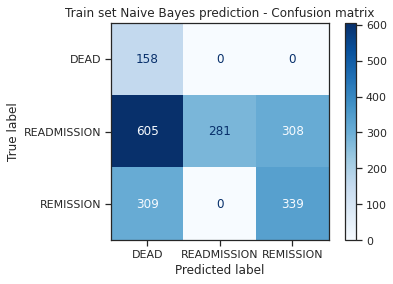

In [57]:
# Confusion Matrices

confusion(nb_model, X_train, y_train, 
          "Train set Naive Bayes prediction - Confusion matrix")

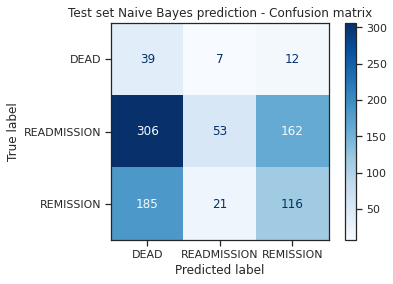

In [58]:
confusion(nb_model, X_test, y_test, 
          "Test set Naive Bayes prediction - Confusion matrix")

#### 3.3.2 GridSearch

Naive Bayes, being naive, does not offer much hyperparameters to play with beside sample_weight (i.e. weights applied to individual samples). As such, we do not perform GridSearch for Naive Bayes.

<hr>

### 3.4 Random Forest

Similar to logistic regression, we see below that the Random Forest model has a difficulty identifying data points tagged with the target variable "DEATH".

#### 3.4.1 Default Parameters

In [59]:
# Model declaration and training

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [60]:
# Model prediction

rf_pred_train = rf_model.predict(X_train)
rf_pred_test = rf_model.predict(X_test)

In [61]:
# Scores
rf_score = classification_score(rf_pred_train, rf_pred_test, 
                                y_train, y_test)

--- Train Set Scores ---
Accuracy: 1.00
F1 score: 1.00

--- Test Set Scores ---
Accuracy: 0.62
F1 score: 0.66


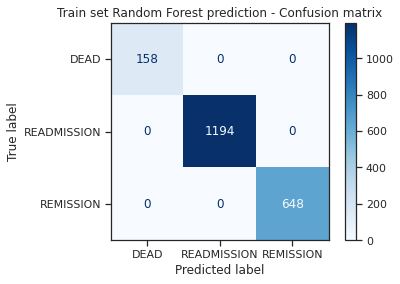

In [62]:
# Confusion Matrices

confusion(rf_model, X_train, y_train, 
          "Train set Random Forest prediction - Confusion matrix")

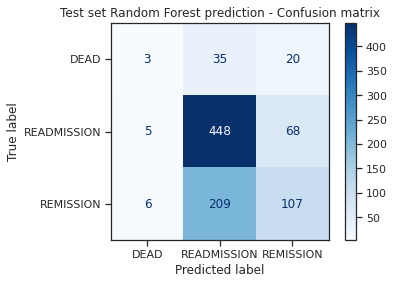

In [63]:
confusion(rf_model, X_test, y_test, 
          "Test set Random Forest prediction - Confusion matrix")

#### 3.2.2 GridSearch

In [64]:
# Going further with GridSearch

parameters = {"criterion":("gini", "entropy"),
              "max_features":("auto", "sqrt", "log2"),
              "max_depth": list(range(5, 40))}

# Model declaration and training

rf_model = RandomForestClassifier()
rf_grid_search = GridSearchCV(rf_model, parameters)
rf_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                       16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                                       26, 27, 28, 29, 30, 31, 32, 33, 34, ...],
                         'max_features': ('auto', 'sqrt', 'log2')})

In [65]:
# Prints the best parameters

rf_grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 31, 'max_features': 'sqrt'}

In [66]:
# Model prediction

rf_grid_pred_train = rf_grid_search.predict(X_train)
rf_grid_pred_test = rf_grid_search.predict(X_test)

# Scores

rf_grid_score = classification_score(rf_grid_pred_train, rf_grid_pred_test, 
                                     y_train, y_test)

--- Train Set Scores ---
Accuracy: 0.86
F1 score: 0.87

--- Test Set Scores ---
Accuracy: 0.63
F1 score: 0.69


<hr>

### 3.5 Support Vector Machine

Similar to logistic regression, we see below that the KNN model has a difficulty identifying data points tagged with the target variable "DEATH".

#### 3.5.1 Default Parameters

In [67]:
# Model declaration and training

svc_model = SVC()
svc_model.fit(X_train, y_train)

SVC()

In [68]:
# Model prediction

svc_pred_train = svc_model.predict(X_train)
svc_pred_test = svc_model.predict(X_test)

In [69]:
# Scores
svc_score = classification_score(svc_pred_train, svc_pred_test, 
                                 y_train, y_test)

--- Train Set Scores ---
Accuracy: 0.72
F1 score: 0.77

--- Test Set Scores ---
Accuracy: 0.62
F1 score: 0.68


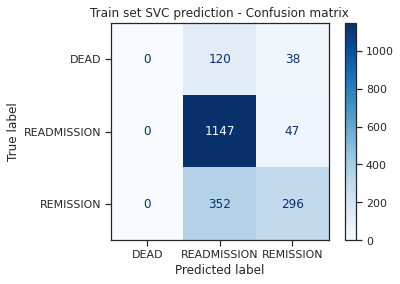

In [70]:
# Confusion Matrices

confusion(svc_model, X_train, y_train, 
          "Train set SVC prediction - Confusion matrix")

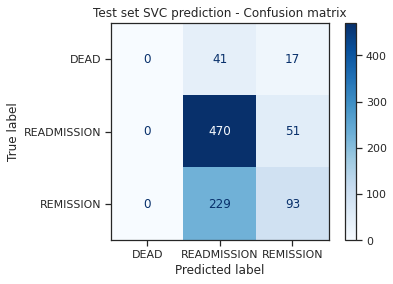

In [71]:
confusion(svc_model, X_test, y_test, 
          "Test set SVC prediction - Confusion matrix")

#### 3.5.2 GridSearch

In [72]:
# Going further with GridSearch

parameters = {"kernel":("linear", "poly", "rbf"),
              "decision_function_shape":("ovo", "ovr"),
              "degree": list(range(3, 20))}

# Model declaration and training

svc_model = SVC()
svc_grid_search = GridSearchCV(svc_model, parameters)
svc_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'decision_function_shape': ('ovo', 'ovr'),
                         'degree': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                    16, 17, 18, 19],
                         'kernel': ('linear', 'poly', 'rbf')})

In [73]:
# Prints the best parameters

svc_grid_search.best_params_

{'decision_function_shape': 'ovo', 'degree': 3, 'kernel': 'rbf'}

In [74]:
# Model prediction

svc_grid_pred_train = svc_grid_search.predict(X_train)
svc_grid_pred_test = svc_grid_search.predict(X_test)

# Scores

svc_grid_score = classification_score(svc_grid_pred_train, svc_grid_pred_test, 
                                      y_train, y_test)

--- Train Set Scores ---
Accuracy: 0.72
F1 score: 0.77

--- Test Set Scores ---
Accuracy: 0.62
F1 score: 0.68


<hr>

### 3.6 Boosting

Similar to logistic regression, but at a lesser extent, we see below that the KNN model has a difficulty identifying data points tagged with the target variable "DEATH".

#### 3.6.1 Default Parameters

In [75]:
# Model declaration and training

boost_model = AdaBoostClassifier()
boost_model.fit(X_train, y_train)

AdaBoostClassifier()

In [76]:
# Model prediction

boost_pred_train = boost_model.predict(X_train)
boost_pred_test = boost_model.predict(X_test)

In [77]:
# Scores
boost_score = classification_score(boost_pred_train, boost_pred_test, 
                                   y_train, y_test)

--- Train Set Scores ---
Accuracy: 0.65
F1 score: 0.69

--- Test Set Scores ---
Accuracy: 0.61
F1 score: 0.66


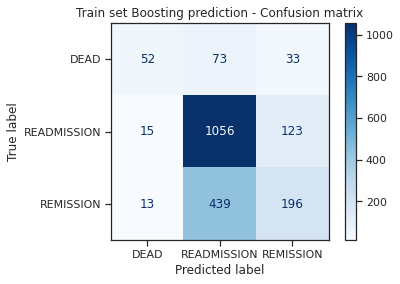

In [78]:
# Confusion Matrices

confusion(boost_model, X_train, y_train, 
          "Train set Boosting prediction - Confusion matrix")

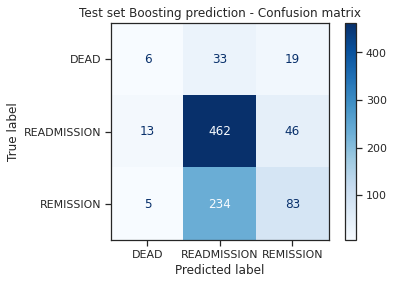

In [79]:
confusion(boost_model, X_test, y_test, 
          "Test set Boosting prediction - Confusion matrix")

#### 3.6.2 GridSearch

In [80]:
# Going further with GridSearch

parameters = {"algorithm":("SAMME", "SAMME.R"),
              "learning_rate":list(map(lambda x: x/10, range(5, 20))),
              "n_estimators": list(range(20, 100, 5))}

# Model declaration and training

boost_model = AdaBoostClassifier()
boost_grid_search = GridSearchCV(boost_model, parameters)
boost_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'algorithm': ('SAMME', 'SAMME.R'),
                         'learning_rate': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1,
                                           1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8,
                                           1.9],
                         'n_estimators': [20, 25, 30, 35, 40, 45, 50, 55, 60,
                                          65, 70, 75, 80, 85, 90, 95]})

In [81]:
# Prints the best parameters

boost_grid_search.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 0.6, 'n_estimators': 95}

In [82]:
# Model prediction

boost_grid_pred_train = boost_grid_search.predict(X_train)
boost_grid_pred_test = boost_grid_search.predict(X_test)

# Scores

boost_grid_score = classification_score(boost_grid_pred_train, boost_grid_pred_test, 
                                        y_train, y_test)

--- Train Set Scores ---
Accuracy: 0.67
F1 score: 0.70

--- Test Set Scores ---
Accuracy: 0.61
F1 score: 0.67


### 3.7 Summarizing Results

Based on the results above, we find that the two best models are **logistic regression** and **random forest**. However, since that their F1 scores are very similar, we use the accuracy score to discriminate between the two models.

**Consequently, we choose to select Random Forest as our best model**, yielding the following scores:

| Metric | Train Set | Test Set |
| :--- | :---: | :---: |
| Accuracy | 0.86 | 0.63 |
| F1 score | 0.87 | 0.69 |


With the following parameters:

| Parameter | Value | Note |
| :--- | :---: | :---: |
| Criterion | entropy | measure the quality of a split |
| Max depth | 31 | maximum tree depth |
| Max features | sqrt | number of features to consider when looking for the best split: $max\_features=\sqrt{n_{features}}$ |

<u>Notes:</u>

The **entropy** criterion is a measure of the disorder or unpredictability in a system. Given a two-class classification $C$, and a sample set $S$, the class distribution at any node can be written as $(p_0, p_1)$ where $p_1 = 1-p_0$ and the entropy of S is the sum of the information:

$$E(S) = -p_0 \times log_2(p_0) - p_1 \times log_2(p_1)$$

Meanwhile, the **gini criterion** refer to the probability of classifying a datapoint incorrectly in a dataset as part of building the random forest classifier.

For $C$ total classes (here 3: "READMISSION", "REMISSION", and "DEATH"), and $p(i)$ the probability of picking a datapoint with class $i$, the Gini Impurity is calculated as:

$$G = \underset{i=1}{\overset{C}{\sum}}p(i)*(1-p(i))$$

We want to minimize this gini impurity metrics (a gini impurity of 0 implies a perfect split of the dataset). 

<Figure size 1080x1080 with 0 Axes>

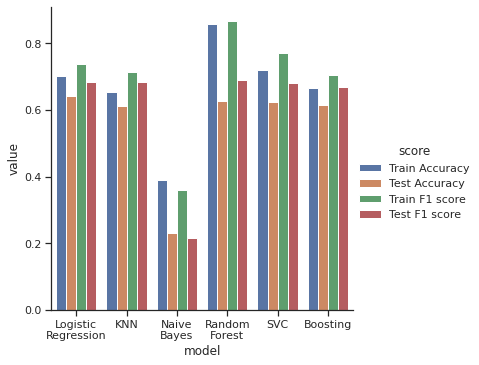

In [83]:
# We plot the results obtained from our best models across all 4 methods

results = {"Logistic\nRegression":lr_grid_score,
           "KNN":knn_grid_score,
           "Naive\nBayes":nb_score,
           "Random\nForest":rf_grid_score,
           "SVC":svc_grid_score,
           "Boosting":boost_grid_score}

results = pd.DataFrame.from_dict(results).melt()

scores = cycle(["Train Accuracy","Test Accuracy","Train F1 score","Test F1 score"])
results['score'] = [next(scores) for _ in range(len(results))]
results.rename(columns = {'variable':'model'}, inplace=True) 

plt.figure(figsize=(15,15))
plot = sns.catplot(x="model", y="value", hue="score", kind="bar", data=results)

## 4. Exploring our best model

### 4.1 Removing ETHNICITY from the dataset

We come back to our note with regards to the dataset (made in Part 2: Data pre-processing).

> consequently, we will need to see if ethnicity has a strong effect on our end result, and, if possible, whether we can do without it.

To do so, we go back to our training and testing dataset and remove the one-hot encoding columns built out of the ETHNICITY variable (present in our original dataset).

The goal here is to:

1. Train a Random Forest Classifier with the same parameters found to maximize our results above, but without using ethnic data

2. Compare the results

3. Draw preliminary interpretations with regards to the variable ETHNICITY

<u>Observations (See code cells below):</u>

We see that removing ETHNICITY from the dataset has a very minor impact on the obtained scores on the testing set:

| Metric | Train Set | Test Set |
| :--- | :---: | :---: |
| Accuracy - With ETHNICITY | 0.86 | 0.63 |
| Accuracy - Without ETHNICITY | 0.81 | 0.62 |
| F1 score - with ETHNICITY | 0.87 | 0.69 |
| F1 score - without ETHNICITY | 0.83 | 0.69 |

- Training accuracy and F1 scores went down by 5 and 4 basis points respectively
- Testing accuracy and F1 scores went down by 1 and 0 basis points respectively

Consequently, we can raise doubts on the usefulness of collecting/using this specific data as part of this type of prediction modeling. There is no question that relying on this variable can be risky and would raise ethical concerns as, beyond the realm of re-hospitalization prediction, the use of ethnic data presents a high risk of misuse (e.g. AI ethicists fear the return of physiognomy in today's discourse, for instance with the power of facial recognition and ethnic profiling. In 2016, a research paper attracted heavy criticism by attempting to infer criminality from facial features).

<hr>

In [84]:
# Removing the ethnic data from our train and test datasets

X_train_wo_eth = X_train[X_train.columns.drop(list(X_train.filter(regex='ETHNICITY')))]
X_test_wo_eth = X_test[X_test.columns.drop(list(X_test.filter(regex='ETHNICITY')))]

In [85]:
# Assigning the Random Forest best parameters to variables

criterion = "entropy"
max_depth = 31
max_features = "sqrt"

In [86]:
# Model declaration and training

rf_model_wo_eth = RandomForestClassifier(criterion=criterion, 
                                         max_depth=max_depth, 
                                         max_features=max_features)

rf_model_wo_eth.fit(X_train_wo_eth, y_train)

RandomForestClassifier(criterion='entropy', max_depth=31, max_features='sqrt')

In [87]:
# Model prediction

rf_pred_train_wo_eth = rf_model_wo_eth.predict(X_train_wo_eth)
rf_pred_test_wo_eth = rf_model_wo_eth.predict(X_test_wo_eth)

In [88]:
# Scores

rf_score_wo_eth = classification_score(rf_pred_train_wo_eth, rf_pred_test_wo_eth, 
                                       y_train, y_test)

--- Train Set Scores ---
Accuracy: 0.81
F1 score: 0.83

--- Test Set Scores ---
Accuracy: 0.62
F1 score: 0.69


<Figure size 1080x1080 with 0 Axes>

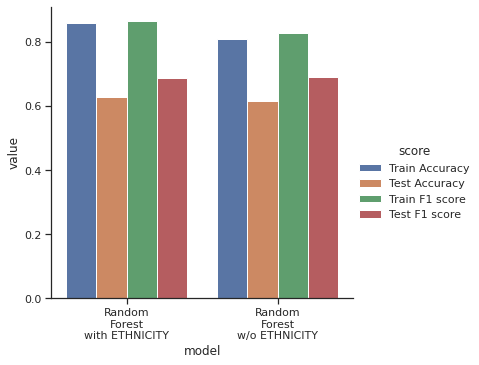

In [89]:
# We plot the results obtained from our best models across all 
# 4 methods

results = {"Random\nForest\nwith ETHNICITY":rf_grid_score,
           "Random\nForest\nw/o ETHNICITY":rf_score_wo_eth}

results = pd.DataFrame.from_dict(results).melt()

scores = cycle(["Train Accuracy","Test Accuracy","Train F1 score","Test F1 score"])
results['score'] = [next(scores) for _ in range(len(results))]
results.rename(columns = {'variable':'model'}, inplace=True) 

plt.figure(figsize=(15,15))
plot = sns.catplot(x="model", y="value", hue="score", kind="bar", data=results)

<hr>


### 4.2 Performing PCA on our Bag of Words representation

We are looking to reduce the size of our training and testing sets. As such, we might want to explore Principal Component Analysis (PCA) to do that by targeting our Bag of Words representation of the DIAGNOSIS column from the original data.

We will apply PCA to the dataset and see how many dimensions we need in the embedded space to obtain a 99% explained variance.

<u>Observations (See code cells below):</u>

We see that, thanks to PCA, we can reduce our dataset size by reducing the dimension of our Bag of Words representation of the DIAGNOSIS column, which we previously created. Using a PCA result that explains 99% of the variance in the bag of words, we see the following results:

| Metric | Train Set | Test Set |
| :--- | :---: | :---: |
| Accuracy | 0.86 | 0.63 |
| Accuracy - with PCA | 1.0 | 0.60 |
| F1 score | 0.87 | 0.69 |
| F1 score - with PCA | 1.0 | 0.64 |

- The accuracy and F1 scores over the training set increase to 1

- However, performing CPA leads to a reduction in the test accuracy and F1 score by a factor of 3 and 5 basis points respectively

In [90]:
# Retrieving the bag of word representation from our pre-processed 
# dataset

X_train_bow = X_train[cv.get_feature_names()]
X_test_bow = X_test[cv.get_feature_names()]

In [91]:
# Fitting a PCA model to find the number of components that has a 99%
# explained variance

number_of_components = 1

while True:
    pca_model = PCA(n_components=number_of_components, 
                    svd_solver='full')
    pca_model.fit(X_train_bow)
    if sum(pca_model.explained_variance_ratio_)>=0.99:
        X_train_pca = pca_model.transform(X_train_bow)
        X_test_pca = pca_model.transform(X_test_bow)
        print("\n99% variance explained mark reached at:\n",
              f"{number_of_components} components")
        break
    number_of_components += 1


99% variance explained mark reached at:
 525 components


In [92]:
# Replacing the bag of word representation in the train and test
# datasets with the PCA

X_train_pca = pd.concat([X_train.drop(cv.get_feature_names(), axis=1), 
                       pd.DataFrame(X_train_pca)], axis = 1)
X_test_pca = pd.concat([X_test.drop(cv.get_feature_names(), axis=1), 
                       pd.DataFrame(X_test_pca)], axis = 1)

In [93]:
# Model declaration and training

rf_model_PCA = RandomForestClassifier(criterion=criterion, 
                                      max_depth=max_depth,
                                      max_features=max_features)

rf_model_PCA.fit(X_train_pca, y_train)

RandomForestClassifier(criterion='entropy', max_depth=31, max_features='sqrt')

In [94]:
# Model prediction

rf_pred_train_PCA = rf_model_PCA.predict(X_train_pca)
rf_pred_test_PCA = rf_model_PCA.predict(X_test_pca)

In [96]:
# Scores

rf_score_PCA = classification_score(rf_pred_train_PCA, rf_pred_test_PCA, 
                                    y_train, y_test)

--- Train Set Scores ---
Accuracy: 1.00
F1 score: 1.00

--- Test Set Scores ---
Accuracy: 0.60
F1 score: 0.64


<Figure size 1080x1080 with 0 Axes>

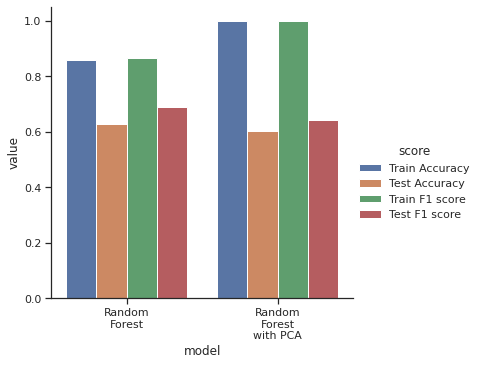

In [97]:
# We plot the results obtained from our best models across all 
# 4 methods

results = {"Random\nForest":rf_grid_score,
           "Random\nForest\nwith PCA":rf_score_PCA}

results = pd.DataFrame.from_dict(results).melt()

scores = cycle(["Train Accuracy","Test Accuracy","Train F1 score","Test F1 score"])
results['score'] = [next(scores) for _ in range(len(results))]
results.rename(columns = {'variable':'model'}, inplace=True) 

plt.figure(figsize=(15,15))
plot = sns.catplot(x="model", y="value", hue="score", kind="bar", data=results)

<hr>


### 4.3 Binary Classification

Up until now, we have looked at performing a 3-class classification problem. I.e. we wanted to predict either READMISSION, DEATH or REMISSION. If we are **purely interested in READMISSION**, we can **merge DEATH and REMISSION** in our target dataset.

<u>Observations (See code cells below):</u>

We see that by going for a binary classification, using grid search, we don't find a much better result in terms of accuracy or F1 score on the test dataset.

| Parameter | Mix maximizing a 3-class classification | Mix maximizing a binary classification |
| :--- | :---: | :---: |
| Criterion | entropy | entropy |
| Max depth | 31 | 43 |
| Max features | sqrt | sqrt |

| Metric | Train Set | Test Set |
| :--- | :---: | :---: |
| Accuracy | 0.86 | 0.63 |
| Accuracy - with only 2 classes | 0.91 | 0.67 |
| F1 score | 0.87 | 0.69 |
| F1 score - with only 2 classes | 0.92 | 0.70 |

As such, we can infer that **in the case of binary classification, a random forest classifier might not be the best model to go for**.

In [98]:
# We replace DEATH and REMISSION instances with NEVER_REHOSPITALIZED, 
# creating a binary classification problem

y_train_binary = y_train.copy()
y_test_binary = y_test.copy()

y_train_binary[y_train_binary=="DEAD"]="NEVER_REHOSPITALIZED"
y_train_binary[y_train_binary=="REMISSION"]="NEVER_REHOSPITALIZED"
y_test_binary[y_test_binary=="DEAD"]="NEVER_REHOSPITALIZED"
y_test_binary[y_test_binary=="REMISSION"]="NEVER_REHOSPITALIZED"

In [99]:
# Going further with GridSearch

parameters = {"criterion":("gini", "entropy"),
              "max_features":("auto", "sqrt", "log2"),
              "max_depth": list(range(5, 50))}

# Model declaration and training

rf_model = RandomForestClassifier()
rf_model_binary = GridSearchCV(rf_model, parameters)
rf_model_binary.fit(X_train, y_train_binary)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                       16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                                       26, 27, 28, 29, 30, 31, 32, 33, 34, ...],
                         'max_features': ('auto', 'sqrt', 'log2')})

In [100]:
# Prints the best parameters

rf_model_binary.best_params_

{'criterion': 'entropy', 'max_depth': 43, 'max_features': 'sqrt'}

In [101]:
# Model prediction

rf_pred_train_bin = rf_model_binary.predict(X_train)
rf_pred_test_bin = rf_model_binary.predict(X_test)

# Scores

rf_score_bin = classification_score(rf_pred_train_bin, rf_pred_test_bin, 
                                    y_train_binary, y_test_binary)

--- Train Set Scores ---
Accuracy: 0.91
F1 score: 0.92

--- Test Set Scores ---
Accuracy: 0.67
F1 score: 0.70


<Figure size 1080x1080 with 0 Axes>

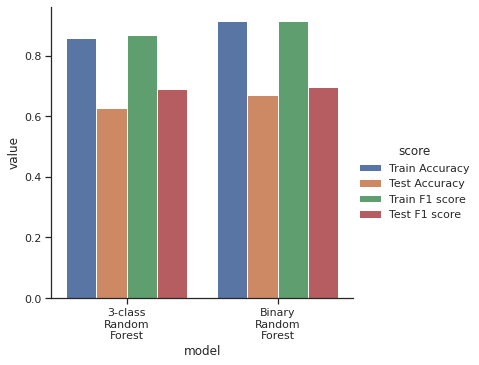

In [102]:
# We plot the results obtained from our best models across all 4 methods

results = {"3-class\nRandom\nForest":rf_grid_score,
           "Binary\nRandom\nForest":rf_score_bin}

results = pd.DataFrame.from_dict(results).melt()

scores = cycle(["Train Accuracy","Test Accuracy","Train F1 score","Test F1 score"])
results['score'] = [next(scores) for _ in range(len(results))]
results.rename(columns = {'variable':'model'}, inplace=True) 

plt.figure(figsize=(15,15))
plot = sns.catplot(x="model", y="value", hue="score", kind="bar", data=results)

<hr>


### 4.4 Overal Parameter Impact Overview

Given that we looked at a lot of different models via grid search, it would be interesting to look into the impact each parameter has on the model performance.

<u>Observations (See code cells below):</u>

- Entropy is marginally better than Gini

- Accuracy seems proportional to max depth, however, past a certain point, the F1 score starts to decrease

- Sqrt and Auto are marginally better than log2

<u>Final outlook on parameters' impact:</u>

Based on our observations, the **main impacting parameter is Max Depth**. However, the overall performance of the model (with regards to the F1 score) plateaus rapidly, indicating that Random Forest has a maximum efficacy in classifying the dataset.

In [103]:
# Recall the parameters used for the random forest grid search

criterions = ("gini", "entropy")

max_features = ("auto", "sqrt", "log2")

max_depths = list(range(5, 60, 5))

<u>Criterion impact overview:</u>

In [107]:
# Training a random forest while varying the criterion

criterion_results = []

for criterion in criterions:
    model = RandomForestClassifier(criterion=criterion,
                                   max_depth=37,
                                   max_features="sqrt")
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"\nModeling with criterion: {criterion}")
    score = classification_score(pred_train, pred_test,
                                 y_train, y_test)
    criterion_results.append(score)


Modeling with criterion: gini
--- Train Set Scores ---
Accuracy: 0.87
F1 score: 0.88

--- Test Set Scores ---
Accuracy: 0.64
F1 score: 0.70

Modeling with criterion: entropy
--- Train Set Scores ---
Accuracy: 0.89
F1 score: 0.90

--- Test Set Scores ---
Accuracy: 0.63
F1 score: 0.69


<Figure size 1080x1080 with 0 Axes>

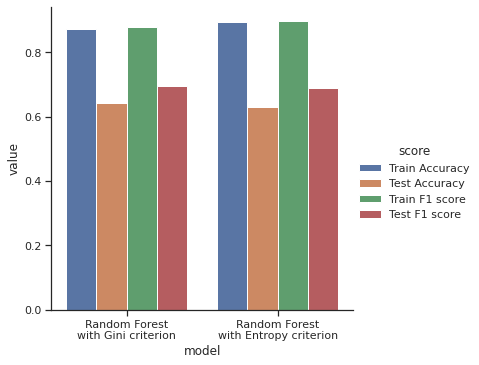

In [108]:
# Plotting the change due to criterion

results = {"Random Forest\nwith Gini criterion":criterion_results[0],
           "Random Forest\nwith Entropy criterion":criterion_results[1]}

results = pd.DataFrame.from_dict(results).melt()

scores = cycle(["Train Accuracy","Test Accuracy","Train F1 score","Test F1 score"])
results['score'] = [next(scores) for _ in range(len(results))]
results.rename(columns = {'variable':'model'}, inplace=True) 

plt.figure(figsize=(15,15))
plot = sns.catplot(x="model", y="value", hue="score", kind="bar", data=results)

<u>Max Depth impact overview:</u>

In [109]:
# Training a random forest while varying the Max Depth

max_depth_results = []

for max_depth in max_depths:
    model = RandomForestClassifier(criterion="gini",
                                   max_depth=max_depth,
                                   max_features="sqrt")
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"\nModeling with max depth: {max_depth}")
    score = classification_score(pred_train, pred_test,
                                 y_train, y_test)
    max_depth_results.append(score)


Modeling with max depth: 5
--- Train Set Scores ---
Accuracy: 0.60
F1 score: 0.75

--- Test Set Scores ---
Accuracy: 0.58
F1 score: 0.73

Modeling with max depth: 10
--- Train Set Scores ---
Accuracy: 0.65
F1 score: 0.75

--- Test Set Scores ---
Accuracy: 0.59
F1 score: 0.72

Modeling with max depth: 15
--- Train Set Scores ---
Accuracy: 0.72
F1 score: 0.77

--- Test Set Scores ---
Accuracy: 0.61
F1 score: 0.71

Modeling with max depth: 20
--- Train Set Scores ---
Accuracy: 0.76
F1 score: 0.79

--- Test Set Scores ---
Accuracy: 0.62
F1 score: 0.69

Modeling with max depth: 25
--- Train Set Scores ---
Accuracy: 0.80
F1 score: 0.82

--- Test Set Scores ---
Accuracy: 0.62
F1 score: 0.70

Modeling with max depth: 30
--- Train Set Scores ---
Accuracy: 0.84
F1 score: 0.85

--- Test Set Scores ---
Accuracy: 0.63
F1 score: 0.70

Modeling with max depth: 35
--- Train Set Scores ---
Accuracy: 0.87
F1 score: 0.87

--- Test Set Scores ---
Accuracy: 0.63
F1 score: 0.69

Modeling with max depth: 40

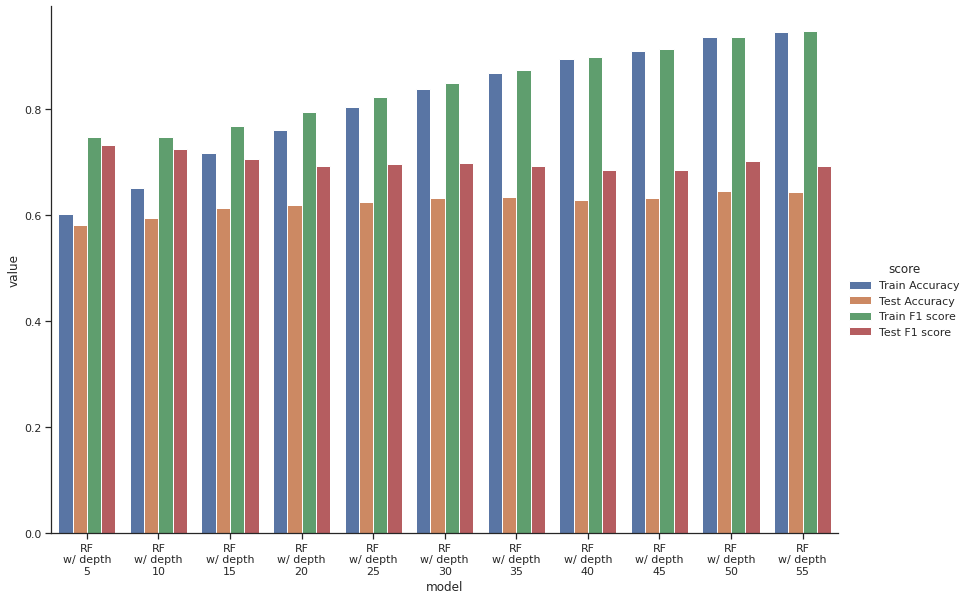

In [110]:
# Plotting the change due to Max Depth

results = {f"RF\nw/ depth\n{d}":max_depth_results[idx] for 
           idx, d in enumerate(max_depths)}

results = pd.DataFrame.from_dict(results).melt()

scores = cycle(["Train Accuracy","Test Accuracy","Train F1 score","Test F1 score"])
results['score'] = [next(scores) for _ in range(len(results))]
results.rename(columns = {'variable':'model'}, inplace=True)

sns.catplot(x="model", y="value", hue="score", kind="bar", data=results,
           height=8.27, aspect=11.7/8.27)

<u>Max Features impact overview:</u>

In [111]:
# Training a random forest while varying the max features

max_features_results = []

for feature in max_features:
    model = RandomForestClassifier(criterion="gini",
                                   max_depth=37,
                                   max_features=feature)
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"\nModeling with max features: {feature}:")
    score = classification_score(pred_train, pred_test,
                                 y_train, y_test)
    max_features_results.append(score)


Modeling with max features: auto:
--- Train Set Scores ---
Accuracy: 0.87
F1 score: 0.88

--- Test Set Scores ---
Accuracy: 0.64
F1 score: 0.70

Modeling with max features: sqrt:
--- Train Set Scores ---
Accuracy: 0.87
F1 score: 0.88

--- Test Set Scores ---
Accuracy: 0.63
F1 score: 0.70

Modeling with max features: log2:
--- Train Set Scores ---
Accuracy: 0.79
F1 score: 0.81

--- Test Set Scores ---
Accuracy: 0.61
F1 score: 0.71


<Figure size 1080x1080 with 0 Axes>

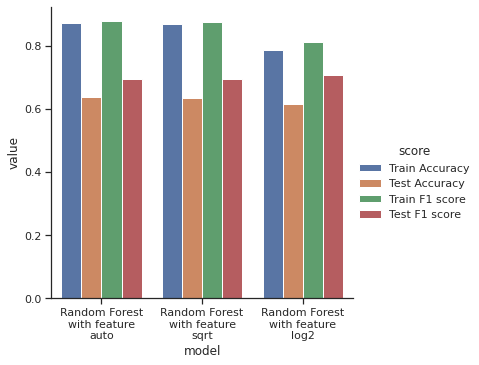

In [112]:
# Plotting the change due to max features

results = {f"Random Forest\nwith feature\n{f}":max_features_results[idx] for 
           idx, f in enumerate(max_features)}

results = pd.DataFrame.from_dict(results).melt()

scores = cycle(["Train Accuracy","Test Accuracy","Train F1 score","Test F1 score"])
results['score'] = [next(scores) for _ in range(len(results))]
results.rename(columns = {'variable':'model'}, inplace=True) 

plt.figure(figsize=(15,15))
plot = sns.catplot(x="model", y="value", hue="score", kind="bar", data=results)

## 5. Conclusion

### 5.1 Variable and Model Choice

After some data pre-processing, we focus our modeling effort on the following variables:

| Variable | Note on preprocessing | 
| :--- | :--- |
| Age | Float variable constructed out of DOB and ADMITTIME |
| GENDER | One-Hot encoded | 
| MARITAL_STATUS | One-Hot encoded | 
| ETHNICITY | One-Hot encoded | 
| INSURANCE | One-Hot encoded | 
| ADMISSION_TYPE | One-Hot encoded | 
| Length of stay | Float variable constructed out of DISCTIME and ADMITTIME |
| DIAGNOSIS | A bag of words reprensentation created via CountVectorizer |

With regards to our classification effort, we have seen six different models. **Each model yielded the following best scores after thorough use of the GridSearch function** (provided by the scikit-learn library):

| Model | Train Accuracy | Test Accuracy | Train F1 Score | Test F1 Score | Our Final Choice |
| :--- | :--- | :--- | :--- | :--- | :---: |
| Logistic Regression | 0.70 | <span style="color:green">**0.64**</span> | 0.74 | 0.68 | <span style="color:red">**$\times$**</span> |
| KNN | 0.65 | 0.61 | 0.71 | 0.68 | <span style="color:red">**$\times$**</span> |
| Naive Bayes | 0.39 | 0.23 | 0.36 | 0.22 | <span style="color:red">**$\times$**</span> |
| Random Forest | <span style="color:green">**0.86**</span> | 0.63 | <span style="color:green">**0.87**</span> | <span style="color:green">**0.69**</span> | <span style="color:green">**$\star$**</span> |
| Support Vector Machine for classification (SVC) | 0.72 | 0.62 | 0.77 | 0.68 | <span style="color:red">**$\times$**</span> |
| Boosting | 0.67 | 0.61 | 0.70 | 0.67 | <span style="color:red">**$\times$**</span> |

### 5.2 Best Model Parameters

Albeit Logistic Regression provides the best test accuracy, it is only 1 basis point better than the Random Forest Classifier. Meanwhile the Random Forest Classifier model leads in all other metrics.

As such, **we choose to continue forward with the Random Forest Classifier** model, which results were maximized under the following parameters:

| Parameter | ArgMax for Model |
| :--- | :---: |
| criterion | <span style="color:green">**Entropy**</span> |
| max_feature | <span style="color:green">**sqrt**</span> |
| max_depth  | <span style="color:green">**31**</span> |


### 5.3 Looking for ways to improve the predictions

We have looked into how to increase the performance of our best model, and have reached the following observations:


1. A **limitation** with regards to training the model **relates to how we represent our data**. It is possible, and rather likely, that we can achieve a better representation/embedding of our variables (such as with our bag of words embedding of the DIAGNOSIS collumn). 


2. **Some variables we have included might be removed**. It can be either for ethical reason (such as with the ETHNICITY variable) or for variance reason. Indeed, it is very likely that some included variables only have a limited, if not null, effect on the end prediction (e.g. removing the ETHNICITY variable from the dataset barely impacted end results).


3. With regards to our selected model (a random forest classifier), we saw that **reducing the number of classes in our dataset from 3 to 2 marginally changed the end predictive power**. As such, we might infer that **we have a limit in performance not set by hyperparameter choice, but by our choice of model**.


### 5.4 Further explorations?

Based on our observations above, we see that we might have end up with limitations set both by our dataset representation but also by our model choice. As such, if further explorations were to be performed, we could focus on the following:

1. **Provide a new embedding/representation for the data** (for instance by including the variable TEXT after a thorough cleaning of the content due to data leakage risk). 


2. **Use more complex models** such as neural networks or deep learning in general (for instance a binary classifier using a dense and deep fully connected neural network could be an avenue of exploration). 